<a href="https://colab.research.google.com/github/daisyleebrowne/Test/blob/main/NAO_sensitivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  # libraries
import requests, zipfile
from io import BytesIO
from zipfile import ZipFile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import signal
from google.colab import files
import io
from io import StringIO
import urllib.request
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import corrected RSL file
fp = '/content/drive/MyDrive/MScR_Python/Corrected_RSL_NAO/1_rsl_nao.csv'
df = pd.read_csv(fp, index_col=0)
df.index = pd.to_datetime(df.index)
df

,RLR,year,month,RLR_detrend,RLR_ancor,RLR_ib,tg_slp,NAO,NAO_detrend
date,,,,,,,,,
1952-10-01,7087.0,1952.0,10,72.833,16.7220,16.680221,101486.2,0.42,0.353
1952-11-01,7091.0,1952.0,11,76.663,16.1775,16.157292,101329.6,-1.51,-1.577
1952-12-01,7097.0,1952.0,12,82.493,31.7825,31.754614,101419.1,-0.31,-0.377
1953-01-01,6943.0,1953.0,1,-71.677,-104.3590,-104.469340,102195.9,-0.02,-0.087
1953-02-01,6922.0,1953.0,2,-92.847,-90.2400,-90.322594,101912.3,0.54,0.473
...,...,...,...,...,...,...,...,...,...
2021-12-01,7230.0,2021.0,12,75.553,24.8425,24.789165,101618.2,0.37,0.397
2022-01-01,7082.0,2022.0,1,-72.617,-105.2990,-105.465709,102771.5,1.46,1.487
2022-02-01,7114.0,2022.0,2,-40.787,-38.1800,-38.288083,102185.5,3.34,3.367


POA here:
- sensitivity statistics i.e. regression and correlation coefficients
- seasonal analysis - will need to split dataframe into seasons
- correlation maps
- for both time periods 1950-2022 and 1993-2022
- need to incorporate uncertainties

###Trialling methods

In [ ]:
# # Code works for winter but not the other seasons
# winter_df = df.groupby(df.index.year, group_keys=False).apply(lambda x: x[(x.index.month >= 12) | (x.index.month <= 2)])
# spring_df = df.groupby(df.index.year, group_keys=False).apply(lambda x: x[(x.index.month >= 5) | (x.index.month <= 3)])
# summer_df = df.groupby(df.index.year, group_keys=False).apply(lambda x: x[(x.index.month >= 6) | (x.index.month <= 8)])
# autumn_df = df.groupby(df.index.year, group_keys=False).apply(lambda x: x[(x.index.month >= 9) | (x.index.month <=11)])

In [ ]:
# summer_df = df.groupby(df.index.year, group_keys=False).apply(lambda x: x[(x.index.month <= 5) | (x.index.month >= 3)])

In [ ]:
# spring_df = df.groupby(df.index.year, group_keys=False).apply(lambda x: x[(x.index.month >= 5) | (x.index.month >= 3)])
# spring_df.head(20)

In [ ]:
# spring_df = df.groupby(df.index.year, group_keys=False).apply(lambda x: x[(x.month >= 7) | (x.month <= 5)])
# spring_df.head(20)

In [ ]:
# # Chat GPT solution...
# # Need to find better alternative
# # Create empty dataframes to store the data for each group of months
# df_0 = pd.DataFrame()
# df_1 = pd.DataFrame()
# df_2 = pd.DataFrame()
# df_3 = pd.DataFrame()

# # Loop over the rows of the original dataframe
# for index, row in df.iterrows():
#     # Extract the month from the datetime index
#     month = index.month

#     # Conditionally append the row to the appropriate dataframe based on the month
#     if month in [12, 1, 2]:
#         winter_df = pd.concat(row, axis=1)
#     elif month in [3, 4, 5]:
#         spring_df = spring_df.append(row)
#     elif month in [6, 7, 8]:
#         summer_df = summer_df.append(row)
#     elif month in [9, 10, 11]:
#         autumn_df = autumn_df.append(row)

In [ ]:
# # Second go at loop...
# winter_df = pd.DataFrame()

# for index, row in df.iterrows():
#   month = index.month
#   if month in [12,1,2]:
#     df_rows = pd.DataFrame(row)
#     winter_df = pd.concat([df_rows, winter_df], axis=1)

Working method!!!

In [ ]:
winter_df = df[df['month'].isin([12,1,2])]
spring_df = df[df['month'].isin([3,4,5])]
summer_df = df[df['month'].isin([6,7,8])]
autumn_df = df[df['month'].isin([9,10,11])]

###Averaging each season
Now need to average each year within each df to get seasonal averages for each year...function?

Winter will need to be average of previous year's Dec and following year's Jan and Feb

Tried to write function..

In [ ]:
spring_av = spring_df.groupby('year').mean().drop(columns=['month']).round(3)
summer_av = summer_df.groupby('year').mean().drop(columns=['month']).round(3)
autumn_av = autumn_df.groupby('year').mean().drop(columns=['month']).round(3)

In [ ]:
# Shift winter years and then average
winter_df['year'] = winter_df['year'].shift(-1)
winter_df

<ipython-input-11-efea9c8d79ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_df['year'] = winter_df['year'].shift(-1)


,RLR,year,month,RLR_detrend,RLR_ancor,RLR_ib,tg_slp,NAO,NAO_detrend
date,,,,,,,,,
1952-12-01,7097.0,1953.0,12,82.493,31.7825,31.754614,101419.1,-0.31,-0.377
1953-01-01,6943.0,1953.0,1,-71.677,-104.3590,-104.469340,102195.9,-0.02,-0.087
1953-02-01,6922.0,1953.0,2,-92.847,-90.2400,-90.322594,101912.3,0.54,0.473
1953-12-01,7126.0,1954.0,12,109.453,58.7425,58.626511,102252.2,0.15,0.084
1954-01-01,6917.0,1954.0,1,-99.717,-132.3990,-132.480291,101900.4,0.10,0.034
...,...,...,...,...,...,...,...,...,...
2021-01-01,7223.0,2021.0,1,70.423,37.7410,37.717937,101331.3,-1.57,-1.545
2021-02-01,7305.0,2021.0,2,152.253,154.8600,154.793050,101767.7,0.50,0.525
2021-12-01,7230.0,2022.0,12,75.553,24.8425,24.789165,101618.2,0.37,0.397


In [ ]:
# winter_df.loc[winter_df.index[-1], 'year shift'] = 2016
winter_av = winter_df.groupby('year').mean().drop(columns=['month']).round(3)

In [ ]:
winter_av

,RLR,RLR_detrend,RLR_ancor,RLR_ib,tg_slp,NAO,NAO_detrend
year,,,,,,,
1953.0,6987.333,-27.344,-54.272,-54.346,101842.433,0.070,0.003
1954.0,7021.333,4.616,-22.312,-22.380,101777.767,0.273,0.208
1955.0,7132.667,113.909,86.980,86.976,101112.400,-0.647,-0.711
1956.0,7023.000,2.202,-24.726,-24.777,101574.800,-1.070,-1.133
1957.0,7052.667,29.828,2.899,2.818,101889.600,2.060,1.999
...,...,...,...,...,...,...,...
2018.0,7138.000,-8.795,-35.724,-35.780,101653.633,0.907,0.928
2019.0,7139.333,-9.503,-36.431,-36.536,102143.233,1.157,1.180
2020.0,7256.333,105.457,78.529,78.443,101955.367,2.850,2.874


###Regression


In [ ]:
# OLS regression
import statsmodels.api as sm
from statsmodels.api import OLS

def sensitivity_regression(df):
  x = df['NAO_detrend']
  y = df['RLR_ib']
  x = sm.add_constant(x)
  model = OLS(y, x)
  res = model.fit()
  return(print(res.summary()))

In [ ]:
from scipy.stats import pearsonr
def pearson_corr(df):
  df_corr = pearsonr(df['NAO_detrend'], df['RLR_ib'])
  return df_corr

In [ ]:
winter_1993 = winter_av.loc['1993':]
spring_1993 = spring_av.loc['1993':]
summer_1993 = summer_av.loc['1993':]
autumn_1993 = autumn_av.loc['1993':]

In [ ]:
winter_1993

,RLR,RLR_detrend,RLR_ancor,RLR_ib,tg_slp,NAO,NAO_detrend
year,,,,,,,
1993.0,7084.333,-11.621,-38.549,-38.689,102478.567,1.410,1.397
1994.0,7132.333,34.338,7.410,7.375,101435.133,1.173,1.162
1995.0,7185.667,85.632,58.703,58.626,101851.300,2.897,2.887
1996.0,7227.000,124.924,97.996,97.967,101370.967,-2.240,-2.248
1997.0,7106.000,1.884,-25.044,-25.129,101923.833,-0.463,-0.470
1998.0,7144.000,37.843,10.915,10.823,102006.867,0.653,0.647
1999.0,7062.333,-45.864,-72.792,-72.883,101990.133,1.550,1.546
2000.0,7064.667,-45.571,-72.500,-72.610,102185.467,2.283,2.280
2001.0,7299.000,186.722,159.794,159.759,101434.767,-0.440,-0.442


In [ ]:
sensitivity_regression(winter_1993)

                            OLS Regression Results                            
Dep. Variable:                 RLR_ib   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.205
Date:                Thu, 19 Oct 2023   Prob (F-statistic):              0.282
Time:                        11:34:06   Log-Likelihood:                -172.16
No. Observations:                  30   AIC:                             348.3
Df Residuals:                      28   BIC:                             351.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.5208     15.818      0.223      

In [ ]:
pearson_corr(winter_1993)

PearsonRResult(statistic=-0.20308982941151726, pvalue=0.2817621046750811)

In [ ]:
sensitivity_regression(spring_1993)

                            OLS Regression Results                            
Dep. Variable:                 RLR_ib   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.543
Date:                Thu, 19 Oct 2023   Prob (F-statistic):              0.224
Time:                        11:34:06   Log-Likelihood:                -148.43
No. Observations:                  30   AIC:                             300.9
Df Residuals:                      28   BIC:                             303.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.5791      6.471      1.635      

In [ ]:
pearson_corr(spring_1993)

PearsonRResult(statistic=-0.2285431777691134, pvalue=0.22446183229267835)

In [ ]:
sensitivity_regression(summer_1993)

                            OLS Regression Results                            
Dep. Variable:                 RLR_ib   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     5.697
Date:                Thu, 19 Oct 2023   Prob (F-statistic):             0.0240
Time:                        11:34:06   Log-Likelihood:                -143.01
No. Observations:                  30   AIC:                             290.0
Df Residuals:                      28   BIC:                             292.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3646      6.008      0.061      

In [ ]:
pearson_corr(summer_1993)

PearsonRResult(statistic=-0.41117250699386765, pvalue=0.023990782423175497)

In [ ]:
sensitivity_regression(autumn_1993)

                            OLS Regression Results                            
Dep. Variable:                 RLR_ib   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     3.756
Date:                Thu, 19 Oct 2023   Prob (F-statistic):             0.0631
Time:                        11:34:06   Log-Likelihood:                -147.93
No. Observations:                  29   AIC:                             299.9
Df Residuals:                      27   BIC:                             302.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.2066      9.542      0.441      

In [ ]:
pearson_corr(autumn_1993)

PearsonRResult(statistic=-0.34944995505156434, pvalue=0.06314932120257204)

In [ ]:
# # alternative code
# spring_av[['NAO_detrend', 'RLR_ib']].corr(method='pearson')

##Correlation maps

In [ ]:
!pip3 install basemap-data-hires

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 MB 8.9 MB/s eta 0:00:00


In [ ]:
!pip3 install basemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 860.7/860.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 34.3 MB/s eta 0:00:00


In [ ]:
import matplotlib.font_manager as font_manager
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [ ]:
# Import arial
font_path = '/content/drive/MyDrive/MScR_Python/Data_files/arial/arial.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

# Settings for Illustrator to read font correctly
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [ ]:
# Import sensitivity data files
fp = '/content/drive/MyDrive/MScR_Python/Sensitivity_data/Sensitivity_1993_2022.csv'
df = pd.read_csv(fp)
df

,ID,Tide gauge,Lat,Lon,corr coeff (RSL-NAO),linear coeff,std error,r^2,P value,0.025,0.975,Significant?,Season
0,1,Brest,48.382850,-4.494838,-0.203,-10.735,9.781,0.041,0.282,-30.772,9.301,1,Winter
1,1,Brest,48.382850,-4.494838,-0.229,-8.801,7.085,0.052,0.224,-23.313,5.712,1,Spring
2,1,Brest,48.382850,-4.494838,-0.411,-12.082,5.062,0.169,0.024,-22.451,-1.713,2,Summer
3,1,Brest,48.382850,-4.494838,-0.349,-17.021,8.783,0.122,-1.938,-35.042,1.000,1,Autumn
4,5,Holyhead,53.313944,-4.620444,0.525,19.232,6.231,0.276,0.005,6.398,32.066,2,Winter
5,5,Holyhead,53.313944,-4.620444,0.092,2.514,5.639,0.009,0.660,-9.152,14.180,1,Spring
6,5,Holyhead,53.313944,-4.620444,-0.467,-16.165,6.125,0.218,0.014,-28.779,-3.551,2,Summer
7,5,Holyhead,53.313944,-4.620444,0.108,5.555,10.668,0.012,0.608,-16.514,27.623,1,Autumn
8,7,Cuxhaven2,53.866670,8.716667,0.813,88.597,12.428,0.662,0.000,63.051,114.143,2,Winter
9,7,Cuxhaven2,53.866670,8.716667,0.174,14.149,15.672,0.030,0.375,-18.065,46.363,1,Spring


In [ ]:
from matplotlib.colors import ListedColormap

In [ ]:
lat = df['Lat'].values
lon = df['Lon'].values
corr = df['corr coeff (RSL-NAO)'].values
TG = df['ID'].values

In [ ]:
pval = df['Significant?'].values

In [ ]:
# cmap = ListedColormap(['#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0',
#                        '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f'])

cmap = ListedColormap(['#67001f', '#b2182b', '#d6604d', '#f4a582','#fddbc7',
                       '#d1e5f0', '#92c5de', '#4393c3', '#2166ac','#053061',])

In [ ]:
plt.rcParams['figure.subplot.hspace'] = 0.1 # more height between subplots
plt.rcParams['figure.subplot.wspace'] = 0.2 # more width between subplots
plt.rcParams["scatter.edgecolors"] = 'black'
plt.rcParams["lines.linewidth"] = 0.7

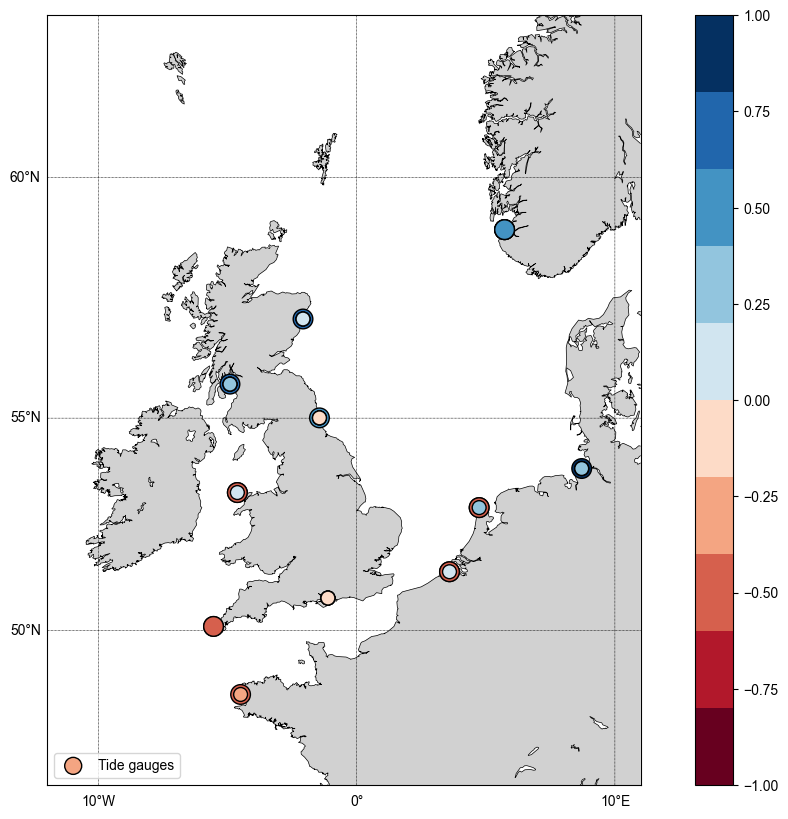

In [ ]:
fig = plt.figure(figsize=(14, 10))
m = Basemap(projection='merc',
            llcrnrlat=46, urcrnrlat=63,
            llcrnrlon=-12,urcrnrlon=11,
            lat_ts=20,
            resolution='i')
m.fillcontinents(color='#D1D1D1', lake_color='white', zorder=1)
m.drawcoastlines(color='black', linewidth=0.5)
m.drawparallels(range(30,80,5), linewidth=0.5, labels=[1,0,0,1], color='black')
m.drawmeridians(range(-20,20,10), linewidth=0.5, labels=[1,0,0,1], color='black')

# scatter of TG stations
sc = m.scatter(lon, lat, latlon=True, marker='o', c=corr, cmap=cmap, alpha=1,
          vmin=-1, vmax=1, label='Tide gauges', s=100*pval, zorder=5)

cbar = fig.colorbar(sc)
plt.legend(loc='lower left')
# plt.savefig('Record_correlation.pdf')

Create subplots...

In [ ]:
corrDJF = df[df['Season'] == 'Winter']['corr coeff (RSL-NAO)'].values
corrMAM = df[df['Season'] == 'Spring']['corr coeff (RSL-NAO)'].values
corrJJA = df[df['Season'] == 'Summer']['corr coeff (RSL-NAO)'].values
corrSON = df[df['Season'] == 'Autumn']['corr coeff (RSL-NAO)'].values

In [ ]:
# latDJF = df[df['Season'] == 'Winter']['Lat'].values
# latMAM = df[df['Season'] == 'Spring']['Lat'].values
# latJJA = df[df['Season'] == 'Summer']['Lat'].values
# latSON = df[df['Season'] == 'Autumn']['Lat'].values

# lonDJF = df[df['Season'] == 'Winter']['Lon'].values
# lonMAM = df[df['Season'] == 'Spring']['Lon'].values
# lonJJA = df[df['Season'] == 'Summer']['Lon'].values
# lonSON = df[df['Season'] == 'Autumn']['Lon'].values

In [ ]:
DJF_df = df[df['Season'] == 'Winter']
MAM_df = df[df['Season'] == 'Spring']
JJA_df = df[df['Season'] == 'Summer']
SON_df = df[df['Season'] == 'Autumn']

In [ ]:
# plt.rcParams['lines.markersize'] = 10

In [ ]:
corr_cbar = df[df['Season'] == 'Winter']['corr coeff (RSL-NAO)'].values

<ipython-input-74-7b7d99a7b125>:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


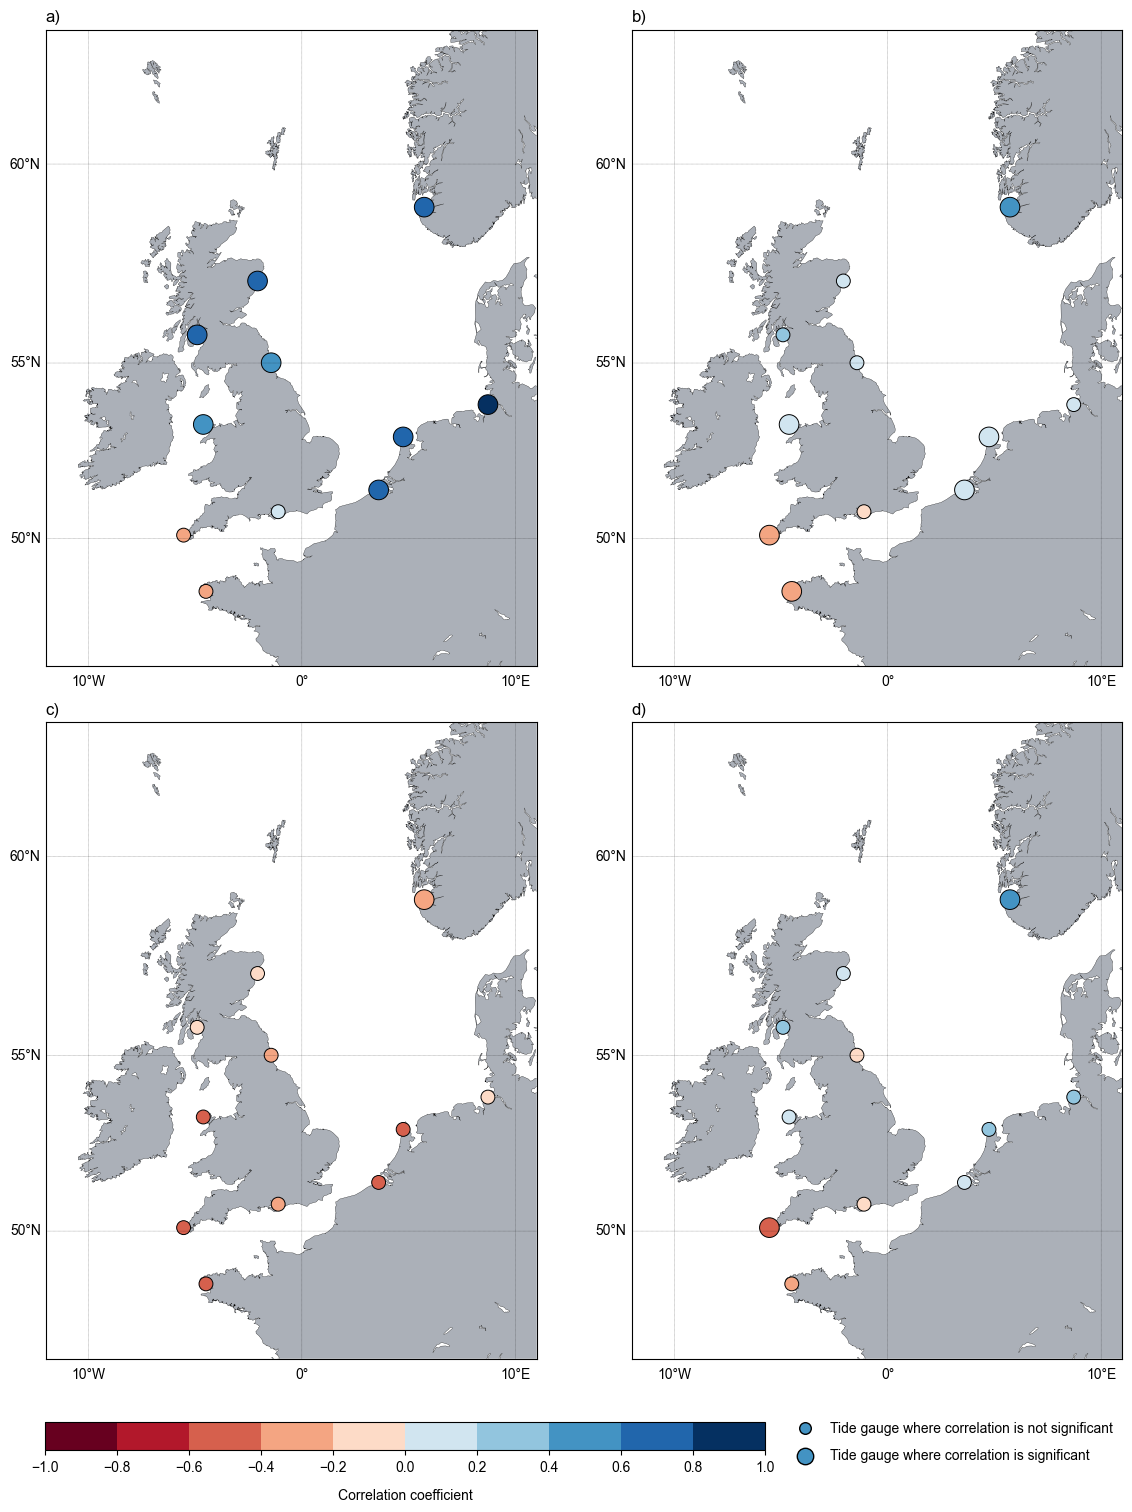

In [ ]:
fig = plt.figure(figsize=(12, 14))

ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (1,0))
ax3 = plt.subplot2grid((2,2), (0,1))
ax4 = plt.subplot2grid((2,2), (1,1))

ax1.set_title('a)', loc='left')
m1 = Basemap(projection='merc',
            llcrnrlat=46, urcrnrlat=63,
            llcrnrlon=-12,urcrnrlon=11,
            lat_ts=20,
            resolution='i',
            ax=ax1)
m1.fillcontinents(color='#ABB0B8', lake_color='white', zorder=1)
m1.drawcoastlines(color='black', linewidth=0.2)
m1.drawparallels(range(30,80,5), linewidth=0.2, labels=[1,0,0,1], color='black', zorder=6)
m1.drawmeridians(range(-20,20,10), linewidth=0.2, labels=[1,0,0,1], color='black', zorder=6)
x, y = m1(DJF_df['Lon'].values, DJF_df['Lat'].values)
s = DJF_df['Significant?'].values
m1.scatter(x, y, c=DJF_df['corr coeff (RSL-NAO)'], vmin=-1, vmax=1,cmap=cmap,
           marker='o', linewidth=0.7, alpha=1, label='Tide gauges',
           s=100*s, zorder=5)

ax2.set_title('c)', loc='left')
m2 = Basemap(projection='merc',
            llcrnrlat=46, urcrnrlat=63,
            llcrnrlon=-12,urcrnrlon=11,
            lat_ts=20,
            resolution='i',
            ax=ax2)
m2.fillcontinents(color='#ABB0B8', lake_color='white')
m2.drawcoastlines(color='black', linewidth=0.2)
m2.drawparallels(range(30,80,5), linewidth=0.2, labels=[1,0,0,1], color='black', zorder=6)
m2.drawmeridians(range(-20,20,10), linewidth=0.2, labels=[1,0,0,1], color='black', zorder=6)
x, y = m2(JJA_df['Lon'].values, JJA_df['Lat'].values)
s = MAM_df['Significant?'].values
m2.scatter(x, y, c=JJA_df['corr coeff (RSL-NAO)'], vmin=-1, vmax=1,cmap=cmap,
           marker='o', linewidth=0.7, alpha=1, label='Tide gauges',
           s=100*s, zorder=5)

ax3.set_title('b)', loc='left')
m3 = Basemap(projection='merc',
            llcrnrlat=46, urcrnrlat=63,
            llcrnrlon=-12,urcrnrlon=11,
            lat_ts=20,
            resolution='i',
            ax=ax3)
m3.fillcontinents(color='#ABB0B8', lake_color='white', zorder=1)
m3.drawcoastlines(color='black', linewidth=0.2)
m3.drawparallels(range(30,80,5), linewidth=0.2, labels=[1,0,0,1], color='black', zorder=6)
m3.drawmeridians(range(-20,20,10), linewidth=0.2, labels=[1,0,0,1], color='black', zorder=6)
x, y = m3(MAM_df['Lon'].values, MAM_df['Lat'].values)
s = JJA_df['Significant?'].values
m3.scatter(x, y, c=MAM_df['corr coeff (RSL-NAO)'], vmin=-1, vmax=1,cmap=cmap,
           marker='o', linewidth=0.7, alpha=1, label='Tide gauges',
           s=100*s, zorder=5)

ax4.set_title('d)', loc='left')
m4 = Basemap(projection='merc',
            llcrnrlat=46, urcrnrlat=63,
            llcrnrlon=-12,urcrnrlon=11,
            lat_ts=20,
            resolution='i',
            ax=ax4)
m4.fillcontinents(color='#ABB0B8', lake_color='white', zorder=1)
m4.drawcoastlines(color='black', linewidth=0.2)
m4.drawparallels(range(30,80,5), linewidth=0.2, labels=[1,0,0,1], color='black', zorder=6)
m4.drawmeridians(range(-20,20,10), linewidth=0.2, labels=[1,0,0,1], color='black', zorder=6)
x, y = m4(SON_df['Lon'].values, SON_df['Lat'].values)
s = SON_df['Significant?'].values
m4 = m4.scatter(x, y, c=SON_df['corr coeff (RSL-NAO)'], vmin=-1, vmax=1,cmap=cmap,
           marker='o', linewidth=0.7, alpha=1, label='Tide gauges',
           s=100*s, zorder=5)


cb_ticks = np.arange(-1.0, 1.2, 0.2)  # Create ticks from -1.0 to 1.0 with 0.2 increments

cbar_ax = fig.add_axes([0.06, -0.04, 0.6, 0.02])
cb = fig.colorbar(m4, cax=cbar_ax, orientation='horizontal', ticks=cb_ticks)
cb.set_label('Correlation coefficient', labelpad=10)


# make legend with dummy points
for a, label_text in zip([1, 2], ['Tide gauge where correlation is not significant', 'Tide gauge where correlation is significant']):
    plt.scatter([], [], c='#4393c3', linewidth=1, alpha=1, s=a*70,
                label=label_text)

plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, bbox_to_anchor=(1.5, 1.5))

plt.tight_layout()
plt.savefig('nao_sl_1950.png', dpi=300, bbox_inches='tight')

In [ ]:
# fig, axes = plt.subplots(2,2,figsize=(16, 12))

# for i, season in enumerate(['Winter', 'Spring', 'Summer', 'Autumn']):
#   ax = axes[i // 2, i % 2]
#   data_subset = df[df['Season'] == season]['corr coeff (RSL-NAO)'].values
#   m = Basemap(projection='merc',
#             llcrnrlat=46, urcrnrlat=63,
#             llcrnrlon=-12,urcrnrlon=11,
#             lat_ts=20,
#             resolution='i',
#             ax=ax1)
#   m.fillcontinents(color='#D1D1D1', lake_color='white', zorder=1)
#   m.drawcoastlines(color='black', linewidth=0.2)
#   m.drawparallels(range(30,80,5), linewidth=0.2, labels=[1,0,0,1], color='black', zorder=6)
#   m.drawmeridians(range(-20,20,10), linewidth=0.2, labels=[1,0,0,1], color='black', zorder=6)
#   x, y = m(df[df['Season'] == season]['Lon'].values, df[df['Season'] == season]['Lat'].values)
#   s = df[df['Season'] == season]['Significant?'].values
#   m.scatter(x, y, c=data_subset, cmap=cmap, marker='o', linewidth=0.5, alpha=1, label='Tide gauges', s=60*s, zorder=5)

# plt.show()

Code below creates maps on top of each other...maybe useful

In [ ]:
# fig = plt.figure(figsize=(14, 10))

# ax = fig.add_subplot(121)
# ax.set_title('Winter')
# m = Basemap(projection='merc',
#             llcrnrlat=46, urcrnrlat=63,
#             llcrnrlon=-12,urcrnrlon=11,
#             lat_ts=20,
#             resolution='l')
# m.fillcontinents(color='#D1D1D1', lake_color='white')
# m.drawcoastlines(color='black', linewidth=0.5)
# m.drawparallels(range(30,80,5), linewidth=0.5, labels=[1,0,0,1], color='black')
# m.drawmeridians(range(-20,20,10), linewidth=0.5, labels=[1,0,0,1], color='black')
# x, y = m(DJF_df['Lon'].values, DJF_df['Lat'].values)
# m.scatter(x, y, c=DJF_df['corr coeff (RSL-NAO)'], cmap=cmap, label='Tide gauges')
# plt.legend(loc='lower left')

# ax = fig.add_subplot(122)
# ax.set_title('Spring')
# m = Basemap(projection='merc',
#             llcrnrlat=46, urcrnrlat=63,
#             llcrnrlon=-12,urcrnrlon=11,
#             lat_ts=20,
#             resolution='l')
# m.fillcontinents(color='#D1D1D1', lake_color='white')
# m.drawcoastlines(color='black', linewidth=0.5)
# m.drawparallels(range(30,80,5), linewidth=0.5, labels=[1,0,0,1], color='black')
# m.drawmeridians(range(-20,20,10), linewidth=0.5, labels=[1,0,0,1], color='black')
# x, y = m(MAM_df['Lon'].values, MAM_df['Lat'].values)
# m.scatter(x, y, c=MAM_df['corr coeff (RSL-NAO)'], cmap=cmap, label='Tide gauges')
# plt.legend(loc='lower left')

# ax = fig.add_subplot(221)
# ax.set_title('Summer')
# m = Basemap(projection='merc',
#             llcrnrlat=46, urcrnrlat=63,
#             llcrnrlon=-12,urcrnrlon=11,
#             lat_ts=20,
#             resolution='l')
# m.fillcontinents(color='#D1D1D1', lake_color='white')
# m.drawcoastlines(color='black', linewidth=0.5)
# m.drawparallels(range(30,80,5), linewidth=0.5, labels=[1,0,0,1], color='black')
# m.drawmeridians(range(-20,20,10), linewidth=0.5, labels=[1,0,0,1], color='black')
# x, y = m(JJA_df['Lon'].values, JJA_df['Lat'].values)
# m.scatter(x, y, c=JJA_df['corr coeff (RSL-NAO)'], cmap=cmap, label='Tide gauges')
# plt.legend(loc='lower left')

# ax = fig.add_subplot(222)
# ax.set_title('Autumn')
# m = Basemap(projection='merc',
#             llcrnrlat=46, urcrnrlat=63,
#             llcrnrlon=-12,urcrnrlon=11,
#             lat_ts=20,
#             resolution='l')
# m.fillcontinents(color='#D1D1D1', lake_color='white')
# m.drawcoastlines(color='black', linewidth=0.5)
# m.drawparallels(range(30,80,5), linewidth=0.5, labels=[1,0,0,1], color='black')
# m.drawmeridians(range(-20,20,10), linewidth=0.5, labels=[1,0,0,1], color='black')
# x, y = m(SON_df['Lon'].values, SON_df['Lat'].values)
# m.scatter(x, y, c=SON_df['corr coeff (RSL-NAO)'], cmap=cmap, label='Tide gauges')
# plt.legend(loc='lower left')